---
- author: Eric J. Ma
- date: 16 March 2019
---

# Introduction

In some datasets, we have truncated or qualified values. These may arise because of a few reasons:

1. One might be that the measurement device has an upper- or lower-bound limit of detection
2. Another might be because of protocol reasons, such as not subjecting an animal to a condition beyond a pre-defined "ethical" limit.

This results in data for which a subset of values are real-valued, but the complementary set of values are imputed as the upper-bound or lower-bound value. 

For machine learning purposes, how do we deal with these bounds? One approach might be to approach it as a two-stage ML problem:

1. In the first stage, predict whether the value is beyond our bounds or not.
2. In the second stage, predict the actual value for those real-valued measurements. 

However, this means we lose the rich information stored in real-valued numbers. Perhaps there could be another way of approaching the problem?

## Qualified Imputation

In this notebook, I want to explore what imputation of qualified values would look like. In particular, I am choosing a parametric strategy, in which I impose a prior distribution on the data, optimize the parameters of the distribution to best fit the data, and finally draw numbers from that distribution to impute such that we remain in a regression setting.

In [1]:
import numpy.random as npr 
import numpy as np

import jax.numpy as jnp
from jax.scipy.stats import norm
import pymc3 as pm

import matplotlib.pyplot as plt

from sklearn.datasets import make_regression


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7401 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


## Generate Data

First off, let's start with simulated data drawn from a standard normal distribution.

In [2]:
X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, n_targets=1)
y = y / 100

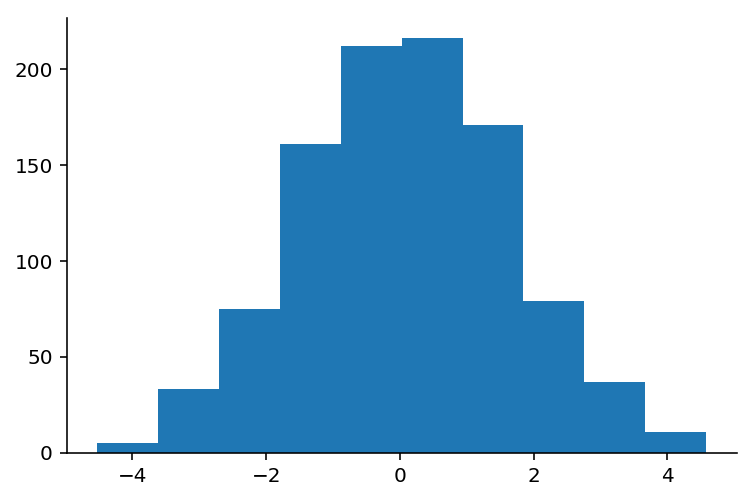

In [3]:
plt.hist(y)
plt.show()

Let us now truncate the data such that any value above 2 is set to 2.

In [4]:
truncation_point = 2

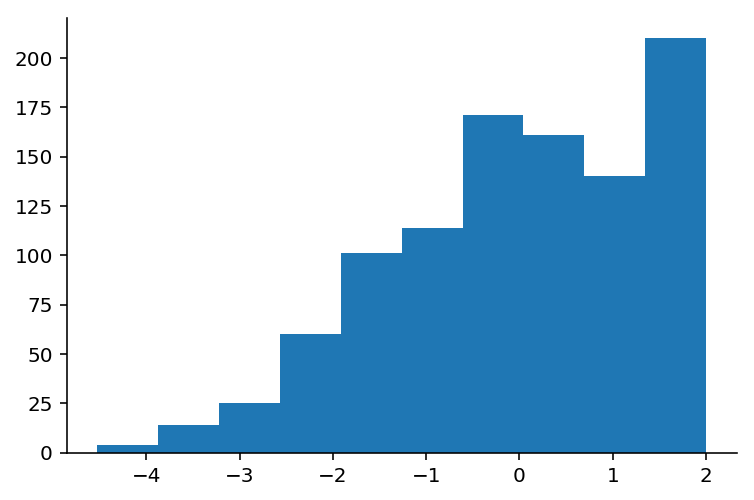

In [5]:
data_trunc = np.concatenate(
    [
        np.clip(y, a_min=None, a_max=truncation_point),
    ]
)
plt.hist(data_trunc)
plt.show()

Here, `data_trunc` represents our actual measured data. The data come from a standard Normal distribution, but there's a truncation point and hence an inflation of points at the truncation point, which is usually known. At the same time, there may be an inflation of values at the truncation point, for which we can model this using a mixture model.

## Inferring Distributional Parameters

Let us see if we are able to infer the standard Normal distribution parameters from `data_trunc`. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Normal_p, Normal_sig, Normal_mu]
100%|██████████| 2500/2500 [00:09<00:00, 262.38it/s]
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.


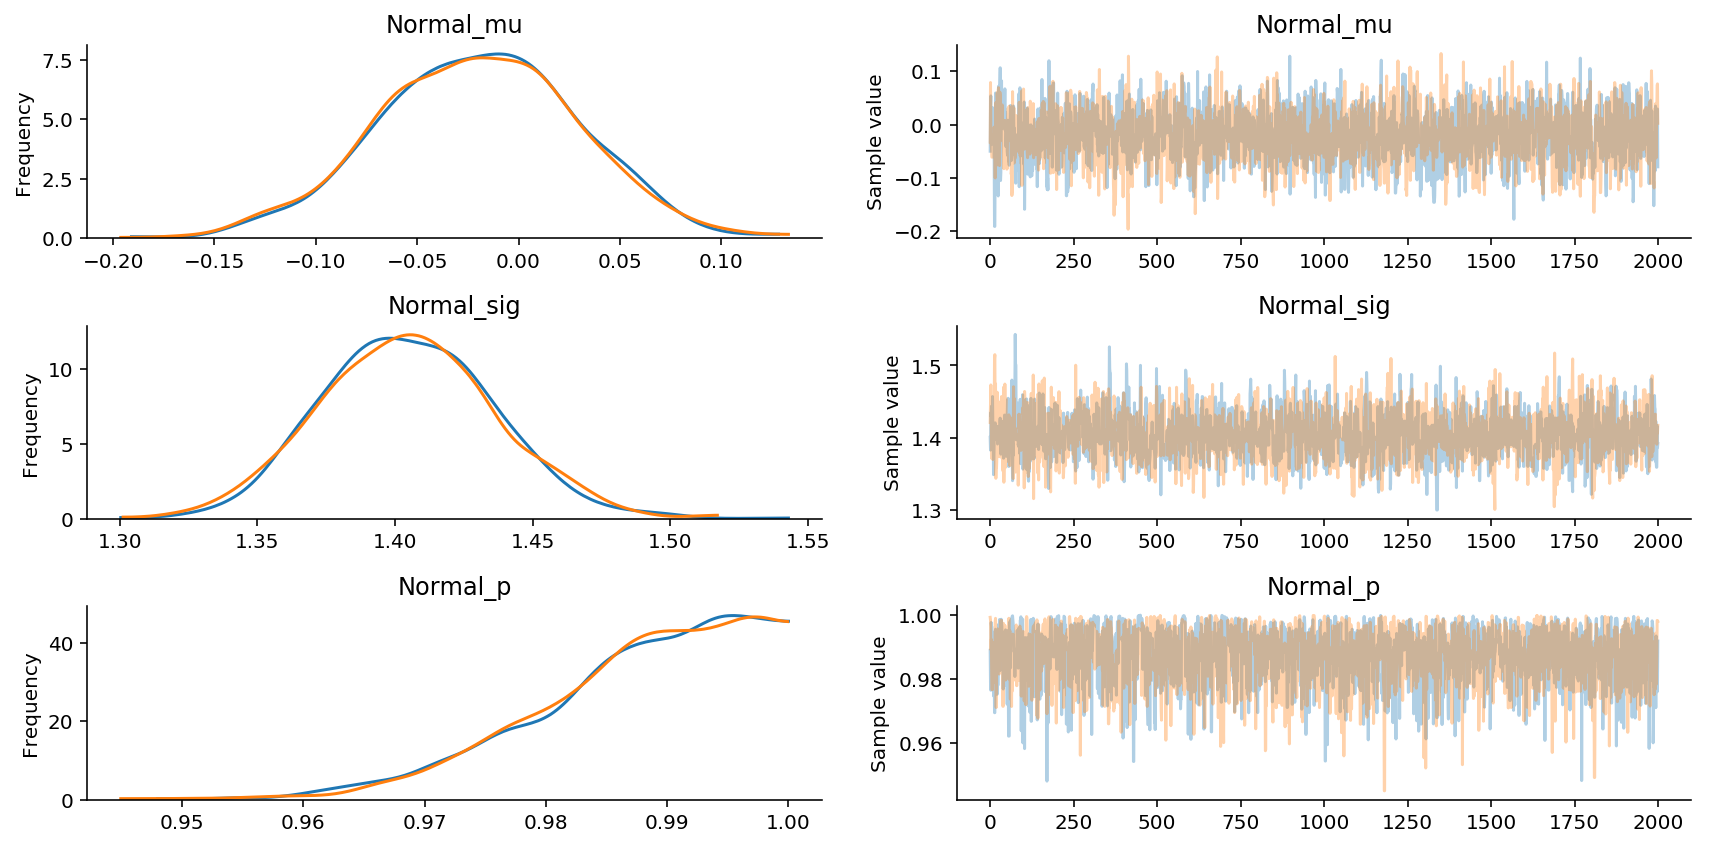

In [6]:
with pm.Model() as model1:
    model1.name = 'Normal'    
    mu = pm.Normal('mu', 0, 10)
    sig = pm.HalfNormal('sig', 10)
    comp_dists = [
        pm.Bound(pm.Normal, upper=truncation_point).dist(mu=mu, sd=sig), 
        pm.Constant.dist(truncation_point),
    ]
    
    p = pm.Beta('p', alpha=1, beta=1)
    weights = [p, 1-p]
    like = pm.Mixture('like', w=weights, comp_dists=comp_dists, observed=data_trunc)
    
with model1:
    trace1 = pm.sample(2000, njobs=1)
    
pm.traceplot(trace1)
plt.show()

Here, with a very obvious spike in the upper truncated values, we are able to accurately recover `mu`, are very close to `sigma`, and are very accurate with `p`, the proportion of values drawn from the truncated standard Normal distribution.

If we tried a different distribution with `(-inf, +inf)` support, we can check other distributions and perform model comparison.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [StudentT_p, StudentT_nu, StudentT_sig, StudentT_mu]
100%|██████████| 2500/2500 [00:12<00:00, 203.80it/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


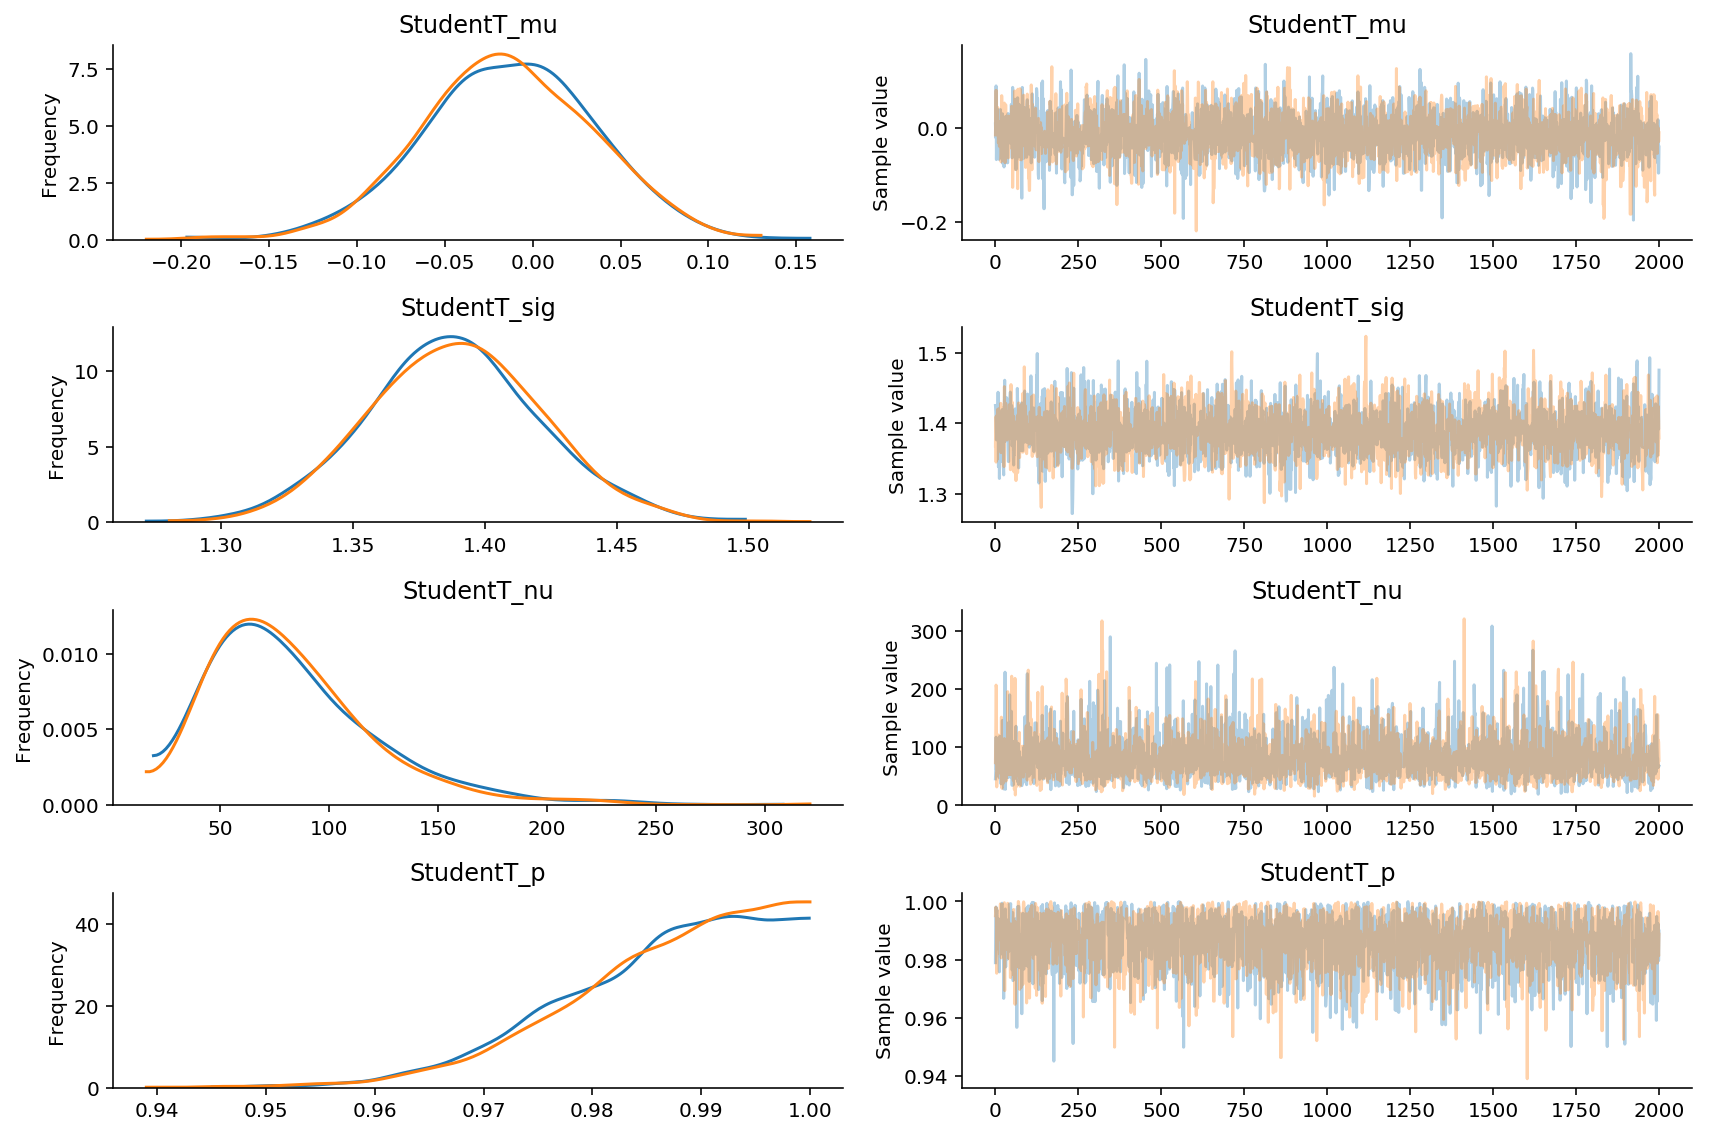

In [7]:
with pm.Model() as model2:
    model2.name = 'StudentT'
    mu = pm.Normal('mu', 0, 10)
    sig = pm.HalfNormal('sig', 5)
    nu = pm.Exponential('nu', lam=1/29.)
    comp_dists = [
        pm.Bound(pm.StudentT, upper=truncation_point).dist(mu=mu, sd=sig, nu=nu), 
        pm.Constant.dist(truncation_point),
    ]
    
    p = pm.Beta('p', alpha=1, beta=1)
    weights = [p, 1-p]
    like = pm.Mixture('like', w=weights, comp_dists=comp_dists, observed=data_trunc)
    trace2 = pm.sample(2000, njobs=1)
    
pm.traceplot(trace2)
plt.show()

In [8]:
pm.compare(
    {
        model1: trace1, 
        model2: trace2
    }
)

/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
Normal,3530.08,2.15,0,1,38.46,0,0
StudentT,3533.86,2.19,3.77,0,38.5,0.78,0


Through model comparison, we see that the Normal distribution WAIC is lower than the StudentT distribution, but of course only marginally. For all practical purposes, I would adjudicate both to be equally good. Because the Normal distribution has fewer parameters to worry about, I would select that as the imputation distribution.

In [9]:
from scipy.stats import truncnorm

impute_mu = trace1['Normal_mu'].mean()
impute_sig = trace1['Normal_sig'].mean()

impute_mu, impute_sig

(-0.02100842, 1.4042627)

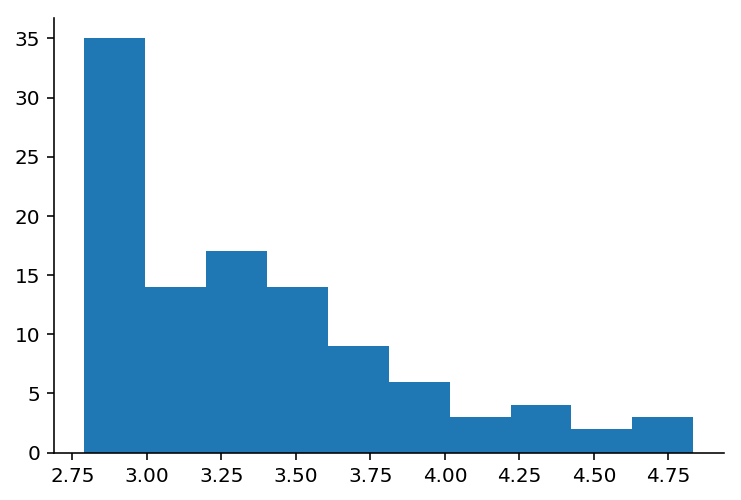

In [10]:
# We set b to some exceedingly high number that is very unlikely, because truncnorm.rvs requires
# both lower (a) and upper (b) to be specified.
imputed_values = truncnorm.rvs(
    a=truncation_point, 
    b=truncation_point*20, 
    loc=impute_mu, 
    scale=impute_sig,
    size=len(data_trunc[data_trunc == truncation_point])
)

plt.hist(imputed_values)
plt.show()

Create a new array with imputed values

In [11]:
idxs, = np.where(data_trunc == truncation_point)
data_imp = np.copy(data_trunc)
np.put(data_imp, idxs, imputed_values)

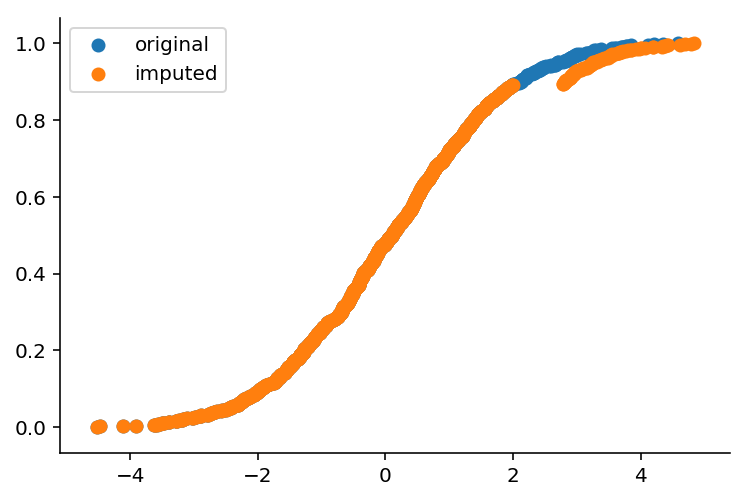

In [12]:
def ecdf_scatter(data, ax, kwargs):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    ax.scatter(x, y, **kwargs)

fig, ax = plt.subplots()

ecdf_scatter(y, ax, dict(label='original'))
ecdf_scatter(data_imp, ax, dict(label='imputed'))
ax.legend()
plt.show()

We don't recover the exact distribution, but something close enough for imputation purposes.

Now, we can try our machine learning task on the imputed data, and compare how a model performs seeing imputed vs. original data.

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [14]:
def variance_explained(est, X, y):
    preds = est.predict(X)
    return 1 - np.var(preds.ravel() - y.ravel()) / np.var(y.ravel())

In [15]:
rfr = RandomForestRegressor(n_estimators=1000)

cv = ShuffleSplit(n_splits=5)
scores_ori = cross_val_score(rfr, X, y, cv=cv, scoring=variance_explained, n_jobs=-1)

In [16]:
scores_imp = cross_val_score(rfr, X, data_imp, cv=cv, scoring=variance_explained, n_jobs=-1)

In [19]:
import pandas as pd

scores_df = pd.DataFrame(
    {
        'original': scores_ori,
        'imputed': scores_imp,
    }
).melt(var_name='data', value_name='model_variance_explained')


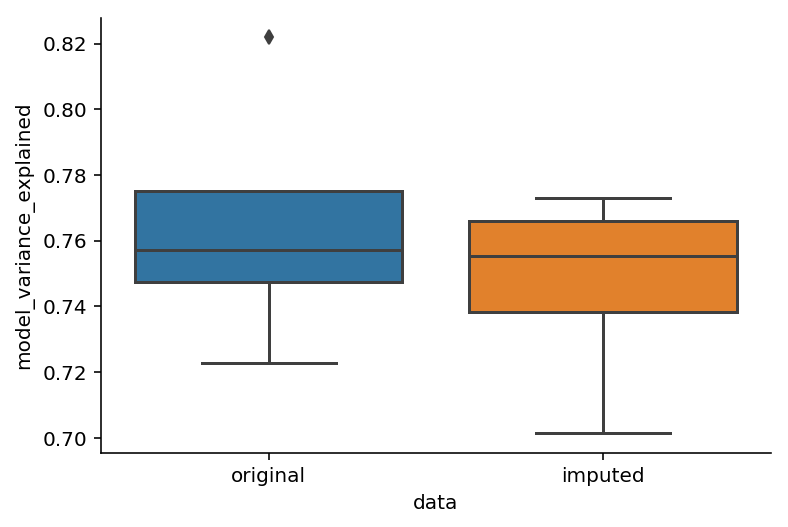

In [21]:
import seaborn as sns

sns.boxplot(data=scores_df, x='data', y='model_variance_explained')
plt.show()

A variance explained of 0.7 means that the residuals were only about 30% of the range of the data. For a model involving synthetic data, that is poor, but for biological data, that is pretty darn amazing.

In a practical setting where any predicted numbers above the truncated values are meaningful only in the sense that "beyond truncation point" == "one meaning", this method allows us to stay within the regression context. 

One has to take care when interpreting prediction values beyond the truncation point. In light of imputation, any predicted values beyond the imputation point can only be treated as "possibly beyond the imputation point", and they carry the same meaning as any other data point beyond the truncation point - "high".